### 모듈, 파일 불러오기

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns  
import warnings
import numpy as np
import matplotlib.font_manager as fm

from matplotlib import font_manager, rc
from scipy.stats import skew, kurtosis
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

font_path = 'C:/WINDOWS/Fonts/Hancom Gothic Bold.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

warnings.filterwarnings('ignore')

In [2]:
path = "C:/Users/USER/Desktop/OIBC2023_data/OIBC2023_data/{}"

incentive = pd.read_csv(path.format('incentive.csv'))
pred = pd.read_csv(path.format('pred.csv'))
weather_actual = pd.read_csv(path.format('weather_actual.csv'))
weather_forecast = pd.read_csv(path.format('weather_forecast.csv'))
gens = pd.read_csv(path.format('gens.csv'))

In [3]:
incentive['time'] = pd.to_datetime(incentive['time'])
pred['time'] = pd.to_datetime(pred['time'])
weather_actual['time'] = pd.to_datetime(weather_actual['time'])
weather_forecast['time'] = pd.to_datetime(weather_forecast['time'])
gens['time'] = pd.to_datetime(gens['time'])

In [4]:
gens['hour'] = gens['time'].dt.hour
gens['day'] = gens['time'].dt.day
gens['month'] = gens['time'].dt.month
gens['date'] = gens['time'].dt.date
gens['weekday'] = gens['time'].dt.weekday

In [5]:
pred = pd.merge(pred, gens, on='time')
pred.rename({'amount_x' : 'pred', 'amount_y' : 'real'}, inplace=True, axis=1)
# pred = pred[(pred['real'] != 0) & (pred['pred'] != 0)]

In [6]:
weather_r1 = weather_forecast[weather_forecast['round'] == 1]
weather_r2 = weather_forecast[weather_forecast['round'] == 2]

In [7]:
model1 = pred[pred['model_id'] == 0]
model2 = pred[pred['model_id'] == 1]
model3 = pred[pred['model_id'] == 2]
model4 = pred[pred['model_id'] == 3]
model5 = pred[pred['model_id'] == 4]

model1_r1 = model1[model1['round'] == 1]
model2_r1 = model2[model2['round'] == 1]
model3_r1 = model3[model3['round'] == 1]
model4_r1 = model4[model4['round'] == 1]
model5_r1 = model5[model5['round'] == 1]

model1_r2 = model1[model1['round'] == 2]
model2_r2 = model2[model2['round'] == 2]
model3_r2 = model3[model3['round'] == 2]
model4_r2 = model4[model4['round'] == 2]
model5_r2 = model5[model5['round'] == 2]

In [8]:
model1_r1 = pd.merge(model1_r1, weather_r1, on='time')
model2_r1 = pd.merge(model2_r1, weather_r1, on='time')
model3_r1 = pd.merge(model3_r1, weather_r1, on='time')
model4_r1 = pd.merge(model4_r1, weather_r1, on='time')
model5_r1 = pd.merge(model5_r1, weather_r1, on='time')

model1_r2 = pd.merge(model1_r2, weather_r2, on='time')
model2_r2 = pd.merge(model2_r2, weather_r2, on='time')
model3_r2 = pd.merge(model3_r2, weather_r2, on='time')
model4_r2 = pd.merge(model4_r2, weather_r2, on='time')
model5_r2 = pd.merge(model5_r2, weather_r2, on='time')

### weather와 시간대를 이용해서 군집화

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
value = ['cloud', 'temp', 'humidity', 'ground_press',
       'wind_speed', 'wind_dir', 'rain', 'snow', 'dew_point', 'vis', 'uv_idx',
       'azimuth', 'elevation']

In [10]:
def make_time_split(df):
    df['hour'] = df['time'].dt.hour
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['date'] = df['time'].dt.date
    df['weekday'] = df['time'].dt.weekday
    
    
    return df

In [11]:
weather = make_time_split(weather_actual)

In [12]:
factor = ['Factor1', 'Factor2', 'Factor3']
distortions = []

In [13]:
def make_cluster_data(df):

    weather_forecast10_scaling = df.copy()

    weather_forecast10_scaling[value] = scaler.fit_transform(df[value])

    # Bartlett Test
    ## 요인분석 모형의 적합성 여부 검정 (요인분석모형으로 적합한지 유의확률로 파악)
    ## H0: 상관관계 행렬이 단위행렬이다 --> 귀무가설이 기각되어야 요인분석 모델 사용가능
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
    chi_square_value, p_value = calculate_bartlett_sphericity(weather_forecast10_scaling[value])
    chi_square_value, p_value # p-value < 0.05 --> 귀무가설 기각
    print(p_value)

    # KMO Test (Kaiser-Meyer-Olkin Test)
    ## 변수들간 상관관계가 다른 변수에 의해 잘 설명되는 정도를 나타내는 값
    ## 이 값이 작으면 요인분석을 위한 변수들의 선정이 적절하지 못하다는 것을 의미
    ## 일반적으로 0.9 이상이면 아주 좋음, 0.8 이상이면 꽤 좋음, 0.7 이상이면 적당함, 0.6 이상이면 평범함, 0.5 미만이면 안 좋음

    from factor_analyzer.factor_analyzer import calculate_kmo
    kmo_all, kmo_model =calculate_kmo(weather_forecast10_scaling[value])
    kmo_model

    # factor 3개로 선택
    fa = FactorAnalyzer(n_factors=3, rotation = "varimax")
    fa.fit(weather_forecast10_scaling[value])
    # FactorAnalyzer()에서 method="ml", rotation="promax" 설정도 가능 #ml: 최대우도방법
    # 다른 옵션 추가 설명: https://github.com/EducationalTestingService/factor_analyzer

    # FA: Factor Loadings
    fa_result_loading = pd.DataFrame(fa.loadings_, 
                                     columns = ['Factor1', 'Factor2', 'Factor3'],
                                     index=weather_forecast10_scaling[value].columns)

    # 시각화
    plt.figure(figsize=(6,10))
    sns.heatmap(fa_result_loading, cmap="Blues", annot=True, fmt='.2f') #소수 둘째자리까지

    X_f = fa.fit_transform(weather_forecast10_scaling[value])
    X_ff = pd.DataFrame(X_f[:,:3], 
                        columns = ['Factor1', 'Factor2', 'Factor3'], 
                        index = weather_forecast10_scaling[value].index)
    distortions = []
    for i in range(1,20):
        km = KMeans(
        n_clusters= i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
        )
        km.fit(X_ff) # elbow 계산할 dataset 적기
        # inertia는 군집내 분산을 의미
        distortions.append(km.inertia_)
    plt.figure(figsize=(10,6))
    plt.plot(range(1,20), distortions, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()
    return X_ff

In [14]:
def clustering(df, n):
    X_ff = df
    model = KMeans(n_clusters=n, random_state=42, algorithm='auto')
    # n_clusters=5 : 군집의 개수 (k)
    # random_state=20210330 : seed 역할 (모델을 일정하게 생성 = 랜덤X)
    model.fit(X_ff)

    # 각 군집(cluster) 표시
    pred = model.predict(X_ff)

    # 4. 원형 데이터에 군집 예측치 추가
    X_ff['k_means_cluster'] = pred

    # 군집별 centroid
    centers = model.cluster_centers_
    return X_ff

0.0


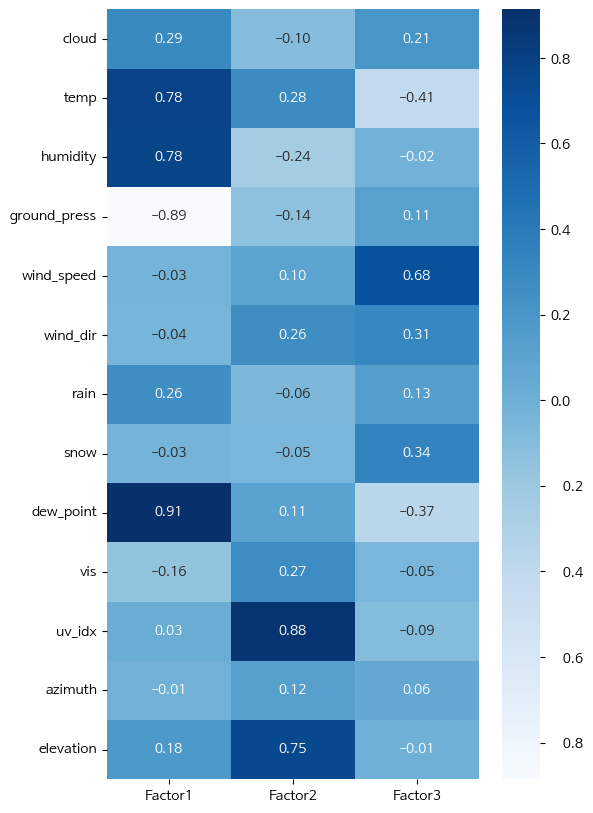

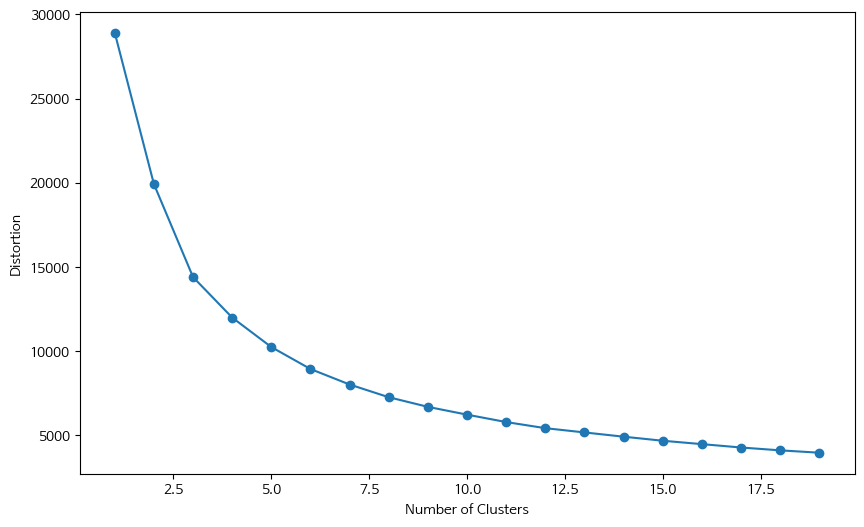

In [15]:
weather = make_cluster_data(weather)

In [16]:
weather = clustering(weather, 10)

In [17]:
weather['time'] = weather_actual['time']
weather = make_time_split(weather)

### round1 모델별 시간대별 평균오차

In [18]:
def make_rmse(df):
    df['error'] = (df['real'] - df['pred'])**2
    return df

In [19]:
model1_r1 = make_rmse(model1_r1)
model2_r1 = make_rmse(model2_r1)
model3_r1 = make_rmse(model3_r1)
model4_r1 = make_rmse(model4_r1)
model5_r1 = make_rmse(model5_r1)

In [20]:
model1_r1_HE = model1_r1.groupby('hour')['error'].mean().reset_index()
model2_r1_HE = model2_r1.groupby('hour')['error'].mean().reset_index()
model3_r1_HE = model3_r1.groupby('hour')['error'].mean().reset_index()
model4_r1_HE = model4_r1.groupby('hour')['error'].mean().reset_index()
model5_r1_HE = model5_r1.groupby('hour')['error'].mean().reset_index()

In [21]:
r1_HE = pd.concat([model1_r1_HE, model2_r1_HE, model3_r1_HE, model4_r1_HE, model5_r1_HE], axis=1)
r1_HE = r1_HE.drop(['hour'], axis=1)
r1_HE.columns = ['model1_err1', 'model1_err2', 'model1_err3', 'model1_err4', 'model1_err5']

In [22]:
r1_HE

,model1_err1,model1_err2,model1_err3,model1_err4,model1_err5
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.157789,0.157789,0.157789,0.157789,0.157789
7,2.469965,12.840273,4.247859,6.632428,76.982908
8,17.713464,36.873915,26.181113,25.904002,112.547293
9,80.795015,92.717920,116.257914,99.584558,250.341890


In [23]:
model1_r1_ME = model1_r1.groupby('month')['error'].mean().reset_index()
model2_r1_ME = model2_r1.groupby('month')['error'].mean().reset_index()
model3_r1_ME = model3_r1.groupby('month')['error'].mean().reset_index()
model4_r1_ME = model4_r1.groupby('month')['error'].mean().reset_index()
model5_r1_ME = model5_r1.groupby('month')['error'].mean().reset_index()

In [24]:
r1_ME = pd.concat([model1_r1_ME, model2_r1_ME, model3_r1_ME, model4_r1_ME, model5_r1_ME], axis=1)
r1_ME = r1_ME.drop(['month'], axis=1)
r1_ME.index=range(1, 13)
r1_ME.columns = ['model1_err1', 'model1_err2', 'model1_err3', 'model1_err4', 'model1_err5']

In [25]:
r1_ME

,model1_err1,model1_err2,model1_err3,model1_err4,model1_err5
1,101.718714,116.236173,129.290426,119.663903,344.096840
2,106.027695,116.943042,131.763770,126.417519,313.235833
3,72.104724,79.129497,97.142301,87.347727,254.879145
4,112.864487,130.603032,144.733802,121.050187,405.555975
5,100.192515,130.089522,132.792141,156.547828,290.202353
6,86.655705,81.978022,94.606241,95.902235,192.286436
7,81.692386,87.961167,90.490966,94.536512,141.367958
8,88.423753,89.061210,93.920508,95.935078,226.828325
9,90.611854,105.727882,109.739912,117.347688,225.214363
10,61.035876,67.485933,91.359514,86.910222,170.539877


In [26]:
model1_r1_MHE = model1_r1.groupby(['month', 'hour'])['error'].mean().reset_index()
model2_r1_MHE = model2_r1.groupby(['month', 'hour'])['error'].mean().reset_index()
model3_r1_MHE = model3_r1.groupby(['month', 'hour'])['error'].mean().reset_index()
model4_r1_MHE = model4_r1.groupby(['month', 'hour'])['error'].mean().reset_index()
model5_r1_MHE = model5_r1.groupby(['month', 'hour'])['error'].mean().reset_index()

In [27]:
model1_r1_MHE

,month,hour,error
0,1,0,0.00000
1,1,1,0.00000
2,1,2,0.00000
3,1,3,0.00000
4,1,4,0.00000
...,...,...,...
283,12,19,1.93264
284,12,20,0.00000
285,12,21,0.00000
286,12,22,0.00000


In [28]:
month_store = model1_r1_MHE['month']
hou_store = model1_r1_MHE['hour']

In [29]:
MHE_round1 = pd.concat([model1_r1_MHE, model2_r1_MHE,model3_r1_MHE,model4_r1_MHE, model5_r1_MHE], axis=1)
MHE_round1.drop(['hour', 'month'], axis=1, inplace=True)
MHE_round1['month'] = month_store
MHE_round1['hour'] = hou_store

# MHE_round1.columns = ['model1_err1', 'model1_err2', 'model1_err3', 'model1_err4', 'model1_err5']

In [30]:
for i in range(1, 13):
    print('------------------------- {}월 -------------------------'.format(i))
    model = MHE_round1[MHE_round1['month'] == i]
    model.index = range(1, 25)
    model.columns = ['model1_err1', 'model1_err2', 'model1_err3', 'model1_err4', 'model1_err5', 'month', 'hour']
    print(model[['model1_err1', 'model1_err2', 'model1_err3', 'model1_err4', 'model1_err5']])

------------------------- 1월 -------------------------
    model1_err1  model1_err2  model1_err3  model1_err4  model1_err5
1      0.000000     0.000000     0.000000     0.000000     0.000000
2      0.000000     0.000000     0.000000     0.000000     0.000000
3      0.000000     0.000000     0.000000     0.000000     0.000000
4      0.000000     0.000000     0.000000     0.000000     0.000000
5      0.000000     0.000000     0.000000     0.000000     0.000000
6      0.000000     0.000000     0.000000     0.000000     0.000000
7      0.000000     0.000000     0.000000     0.000000     0.000000
8      0.239789     0.180330     0.003990     0.351938   147.505707
9      2.294799    40.990542     0.282173     4.181126    69.162820
10    24.925624   115.268359    37.306277    51.977027   140.842744
11   168.218007   176.268476   206.096483   228.527365   558.120737
12   347.307452   349.710839   457.695286   420.233813  1056.626008
13   401.509649   417.991991   495.993947   525.351111  1446.

+ 과제 : 모델별 오차율이 높고 낮은때 시간대와 월 날씨 특성 파악하기

In [31]:
model1 = pd.merge(model1_r1[['pred', 'time']], model1_r2[['pred', 'time']], on='time')
model1 = pd.merge(model1, gens[['time', 'amount']], on='time')
model1 = pd.merge(model1, weather, on='time')

model2 = pd.merge(model2_r1[['pred', 'time']], model2_r2[['pred', 'time']], on='time')
model2 = pd.merge(model2, gens[['time', 'amount']], on='time')
model2 = pd.merge(model2, weather, on='time')

model3 = pd.merge(model3_r1[['pred', 'time']], model3_r2[['pred', 'time']], on='time')
model3 = pd.merge(model3, gens[['time', 'amount']], on='time')
model3 = pd.merge(model3, weather, on='time')

model4 = pd.merge(model4_r1[['pred', 'time']], model4_r2[['pred', 'time']], on='time')
model4 = pd.merge(model4, gens[['time', 'amount']], on='time')
model4 = pd.merge(model4, weather, on='time')

model5 = pd.merge(model5_r1[['pred', 'time']], model5_r2[['pred', 'time']], on='time')
model5 = pd.merge(model5, gens[['time', 'amount']], on='time')
model5 = pd.merge(model5, weather, on='time')


In [32]:
model1['error_rate'] = (abs(((model1['pred_x'] + model1['pred_y']) / 2) - model1['amount']) / 99) *100
model2['error_rate'] = (abs(((model2['pred_x'] + model2['pred_y']) / 2) - model2['amount']) / 99) *100
model3['error_rate'] = (abs(((model3['pred_x'] + model3['pred_y']) / 2) - model3['amount']) / 99) *100
model4['error_rate'] = (abs(((model4['pred_x'] + model4['pred_y']) / 2) - model4['amount']) / 99) *100
model5['error_rate'] = (abs(((model5['pred_x'] + model5['pred_y']) / 2) - model5['amount']) / 99) *100


In [33]:
model1 = model1[(model1['error_rate'] != 0) & (model1['error_rate'] != 1)]
model2 = model2[(model2['error_rate'] != 0) & (model2['error_rate'] != 1)]
model3 = model3[(model3['error_rate'] != 0) & (model3['error_rate'] != 1)]
model4 = model4[(model4['error_rate'] != 0) & (model4['error_rate'] != 1)]
model5 = model5[(model5['error_rate'] != 0) & (model5['error_rate'] != 1)]

In [34]:
def find_big_error(df):
    model = df[df['error_rate'] >= 8]
    return model

In [35]:
model1 = make_time_split(model1)
model2 = make_time_split(model2)
model3 = make_time_split(model3)
model4 = make_time_split(model4)
model5 = make_time_split(model5)

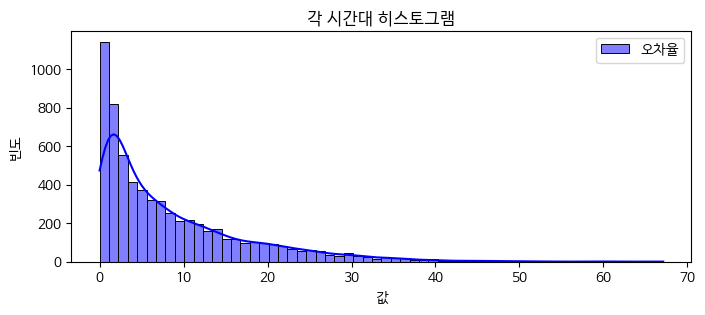

In [36]:
plt.figure(figsize=(8, 3))
sns.histplot(data=model1, x='error_rate', kde=True, label='오차율', color='blue')
# sns.histplot(data=model1, x='amount_y', kde=True, label='17시', color='red')
plt.title('각 시간대 히스토그램')
plt.xlabel('값')
plt.ylabel('빈도')
plt.legend()

In [37]:
len(model1)

6414

In [38]:
model1_BE = find_big_error(model1)
model2_BE = find_big_error(model2)
model3_BE = find_big_error(model3)
model4_BE = find_big_error(model4)
model5_BE = find_big_error(model5)

+ 모델별로 오차율의 크기 빈도가 다르다

In [39]:
def time_feature_dist(df, df2):
    total_hour = df['hour'].value_counts()
    total_month = df['month'].value_counts()
        
    hour_dist = df2['hour'].value_counts()
    month_dist = df2['month'].value_counts()
#     print('----------------- 전체시간 분포-----------------')
#     print(total_hour)
#     print(total_month)
    
#     print('----------------- 전체 월 분포 -----------------')
#     print(hour_dist)
#     print(month_dist)
    
    percentage_h = (hour_dist/total_hour) * 100
    percentage_m = (month_dist/total_month) * 100
#     print('8% 이상의 에러들의 전체에서 차지하는 비중')
    print('시간대별 비율')
    print(percentage_h)
    print('월별 비율')  
    print(percentage_m)
    return percentage_h, percentage_m

In [40]:
print('model1')
h1, m1 = time_feature_dist(model1, model1_BE)
print('model2')
h2, m2 = time_feature_dist(model2, model2_BE)
print('model3')
h3, m3 = time_feature_dist(model3, model3_BE)
print('model4')
h4, m4 = time_feature_dist(model4, model4_BE)
print('model5')
h5, m5 = time_feature_dist(model5, model5_BE)

model_hour_dist = pd.concat([h1, h2, h3, h4, h5], axis=1)
model_hour_dist.columns = ['model1', 'model2', 'model3', 'model4', 'model5']
model_hour_dist = model_hour_dist.idxmin(axis=1)

model_month_dist = pd.concat([m1, m2, m3, m4, m5], axis=1)
model_month_dist.columns = ['model1', 'model2', 'model3', 'model4', 'model5']
model_month_dist = model_month_dist.idxmin(axis=1)


model1
시간대별 비율
6           NaN
7           NaN
8      6.485356
9     33.195021
10    53.112033
11    61.825726
12    60.788382
13    62.033195
14    63.900415
15    60.165975
16    55.601660
17    36.929461
18    12.033195
19          NaN
20          NaN
Name: hour, dtype: float64
월별 비율
1     40.206186
2     43.390805
3     33.498759
4     38.265306
5     39.443155
6     36.302521
7     37.389381
8     39.281289
9     40.512821
10    34.358974
11    34.114583
12    39.798489
Name: month, dtype: float64
model2
시간대별 비율
6           NaN
7      1.515152
8     15.778252
9     34.647303
10    51.452282
11    60.580913
12    62.033195
13    59.875260
14    61.746362
15    61.618257
16    56.016598
17    35.892116
18    17.647059
19     2.954545
20          NaN
Name: hour, dtype: float64
월별 비율
1     50.546448
2     45.882353
3     31.898734
4     39.795918
5     40.139211
6     37.142857
7     37.500000
8     40.322581
9     38.046272
10    35.888502
11    40.281690
12    48.663102
Name: month,

### 시간대와 월별로 각 model의 오차율이 8% 이상인 비중

In [41]:
display(model_hour_dist)
display(model_month_dist)

6        NaN
7     model4
8     model1
9     model1
10    model2
11    model4
12    model4
13    model4
14    model3
15    model1
16    model1
17    model2
18    model1
19    model4
20       NaN
dtype: object

1     model3
2     model4
3     model4
4     model4
5     model1
6     model1
7     model1
8     model1
9     model2
10    model1
11    model1
12    model4
dtype: object

In [42]:
model1_BE

,pred_x,time,pred_y,amount,Factor1,Factor2,Factor3,k_means_cluster,hour,day,month,date,weekday,error_rate
9,24.46520,2022-06-19 10:00:00+09:00,31.0740,18.0,0.853821,0.330089,-0.381312,9,10,19,6,2022-06-19,6,9.868283
10,32.48850,2022-06-19 11:00:00+09:00,41.4121,59.0,0.854744,0.711311,-0.381410,9,11,19,6,2022-06-19,6,22.272424
13,55.99350,2022-06-19 14:00:00+09:00,57.0286,46.0,0.846097,1.432091,-0.231719,9,14,19,6,2022-06-19,6,10.617222
14,54.28280,2022-06-19 15:00:00+09:00,55.8605,41.0,0.678314,2.219304,-0.229586,7,15,19,6,2022-06-19,6,14.213788
31,9.74378,2022-06-20 08:00:00+09:00,12.1641,20.0,0.891778,0.037904,-0.600460,2,8,20,6,2022-06-20,0,9.137434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,65.77010,2023-10-14 13:00:00+09:00,67.4954,56.0,0.158367,1.026425,-0.070123,9,13,14,10,2023-10-14,5,10.740152
11555,68.66020,2023-10-15 12:00:00+09:00,60.4846,51.0,0.206819,1.058098,0.397092,9,12,15,10,2023-10-15,6,13.709495
11556,68.08340,2023-10-15 13:00:00+09:00,61.0122,82.0,0.089985,0.904971,0.414155,9,13,15,10,2023-10-15,6,17.628485
11557,61.47920,2023-10-15 14:00:00+09:00,62.4748,45.0,-0.047501,1.477042,0.333641,9,14,15,10,2023-10-15,6,17.148485


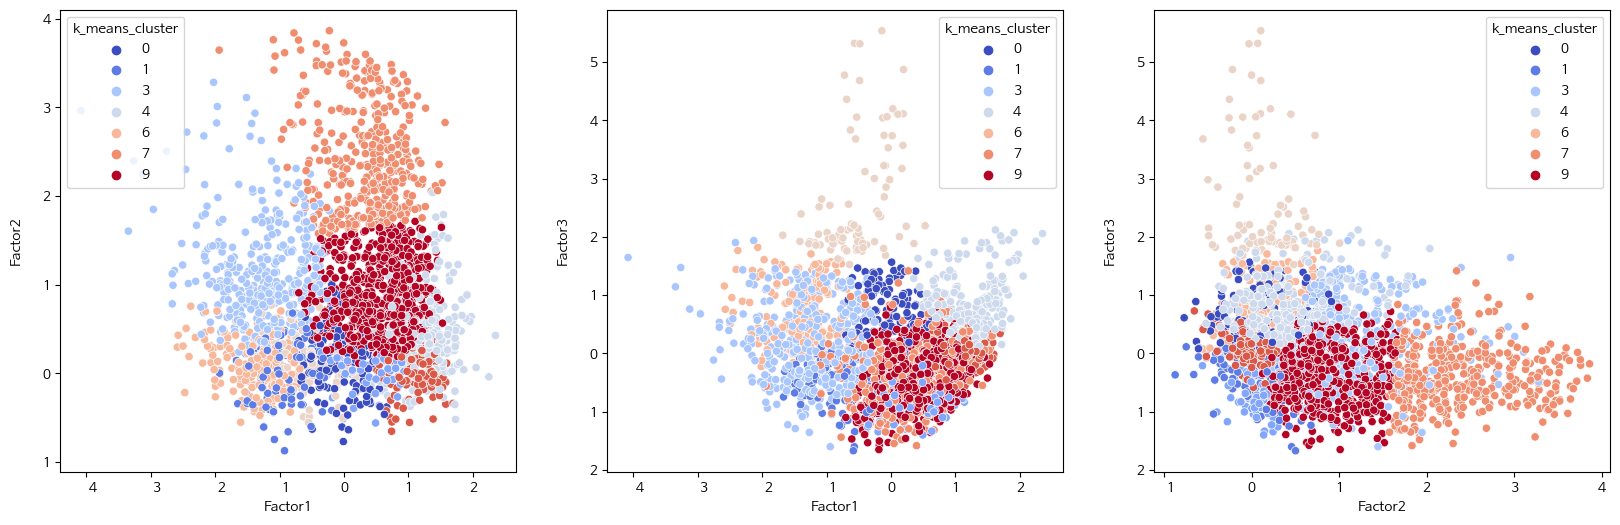

In [43]:
plt.figure(figsize=(20, 6))

X = model1_BE

plt.subplot(131)
sns.scatterplot(x=X['Factor1'], y=X['Factor2'], data=X, hue=X.k_means_cluster, palette='coolwarm')
# plt.scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

plt.subplot(132)
sns.scatterplot(x=X['Factor1'], y=X['Factor3'], data=X, hue=X.k_means_cluster, palette='coolwarm')
# plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(133)
sns.scatterplot(x=X['Factor2'], y=X['Factor3'], data=X, hue=X.k_means_cluster, palette='coolwarm')
# plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.show()

### OLS

In [44]:
real_energy = pd.merge(gens, weather_r1, on='time')
real_energy['hour'] = real_energy['time'].dt.hour
real_energy['day'] = real_energy['time'].dt.day
real_energy['month'] = real_energy['time'].dt.month
real_energy['date'] = real_energy['time'].dt.date
real_energy['weekday'] = real_energy['time'].dt.weekday

In [45]:
correlation_matrix = real_energy.corr()['amount']

# # 히트맵을 그립니다.
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('상관 관계 히트맵')
# plt.show()
correlation_matrix

amount          1.000000
hour            0.151715
day            -0.022487
month          -0.021679
weekday        -0.000228
round                NaN
cloud          -0.171595
temp            0.089671
humidity       -0.311427
ground_press    0.029093
wind_speed      0.057569
wind_dir        0.225361
rain           -0.070353
snow           -0.056575
dew_point      -0.043500
vis             0.160240
uv_idx          0.724537
azimuth         0.067183
elevation       0.737651
Name: amount, dtype: float64

In [46]:
col = ['cloud', 'temp', 'humidity',
       'ground_press', 'wind_speed', 'wind_dir', 'snow', 'dew_point', 'uv_idx', 'azimuth', 'elevation']

In [47]:
import statsmodels.api as sm

In [48]:
X = real_energy[col]
y = real_energy['amount']

# 상수 (절편)를 추가
X = sm.add_constant(X)

# OLS 모델 생성
model = sm.OLS(y, X)

# 모델 학습
results = model.fit()

In [49]:
# 회귀 결과 요약
print(results.summary())

# 회귀 계수 출력
print("회귀 계수 (coefficients):")
print(results.params)


                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     2744.
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:42:21   Log-Likelihood:                -46717.
No. Observations:               11616   AIC:                         9.346e+04
Df Residuals:                   11604   BIC:                         9.355e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -89.7546     32.913     -2.727   